## Bitcoin Fear & Greed Index
***

### Introduction
***
This is an attempt to create a sentiment index for Bitcoin. This sentiment index can be used for the purpose of trading into bitcoins and also as an indicator of overall mood. I have broadly divided the components of this index in two categories as follows.

**Market Sentiment**
 - Momentum
 - Price / MA
 - Implied Volatility (VIX)
 - Simulated Price (using Geometric Brownian Motion)
 
**Social Sentiment**
 - Google search trend
 - News articles
 - Reddit posts

### Methodology
***

Data points that are used for creating this index are from 1 May 2018 to 31 May 2018. This project is only for PoC purpose. The limitation of the dataset is majorly due to non availability of historical social sentiment data with free api's. The methodology used to compute various factors is stated below. The construction methodology used to combine all the indicators is from Market Mood Index by Smallcase (http://mmi.smallcase.com/)

- **Momentum**: Momentum is calculated as
$$momentum = \frac{90dEMA - 30dEMA}{90dEMA}$$


- **Implied Volatility**: Volatility Index is calculated using forecasted volatility using GARCH(1,1) model. Forecast for next 24 periods of volatility is made and calculated as $$\left ( \frac{VIX_t}{100} \right )^2 = \frac{1}{n}\sum_{k=1}^{n}E_{t}^{Q}\left [ \tilde{h}_{t+\frac{\tau_0 k}{n}} \right ]$$

  Refrence: Hao, J., & Zhang, J. E. (2013). GARCH option pricing models, the CBOE VIX, and variance risk premium. Journal of Financial Econometrics, 11(3), 556-580.


- **Price / 125d MA**


- **Google Search Trend**: Interest over time from google trends for the keyword 'bitcoin'


- **News**: Sentiment analysis using vaderSentiment api of news articles with 'bitcoin' keyword in their title


- **Reddit**: Top posts titles in subreddit r/bitcoin are captured and sentiment analysis using vaderSentiment is performed


In [1]:
import numpy as np
import pandas as pd
import glob
import json
import datetime 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from arch import arch_model

import warnings
warnings.filterwarnings("ignore")

## Data cleaning and resampling

 - Original bitcoin price data is of 30min frequency, but needs to be resampled to 60min frequency as the social sentiment data is only available at 60min frequency
 - Series is extracted for a period more than required so as to factor in for moving averages

In [49]:
df = pd.read_csv('./data/bitcoin.csv', sep = '\t')
df.Timestamp = pd.to_datetime(df.Timestamp) # convert timestamp to datetime format
df.replace(to_replace='—', value = '', inplace=True) # replace - values with blanks
df.set_index(df.Timestamp,drop=True,inplace=True) # set timestamp as index
df.drop(labels = 'Timestamp', axis = 1, inplace=True) # drop timestamp column

# convert data to numeric
df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']] = df[['Open','High','Low','Volume (BTC)','Volume (Currency)','Weighted Price','Close']].apply(pd.to_numeric)

df.fillna(method='ffill',inplace=True) # forward fill na values
df.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2012-12-31 00:00:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 00:30:00,13.2,13.2,13.20,13.20,0.23,3.04,13.20
2012-12-31 01:00:00,13.2,13.2,13.18,13.18,2.28,30.05,13.18
2012-12-31 01:30:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20
2012-12-31 02:00:00,13.2,13.2,13.20,13.20,23.00,303.60,13.20


Text(0.5,1,'Bitcoin Prices')

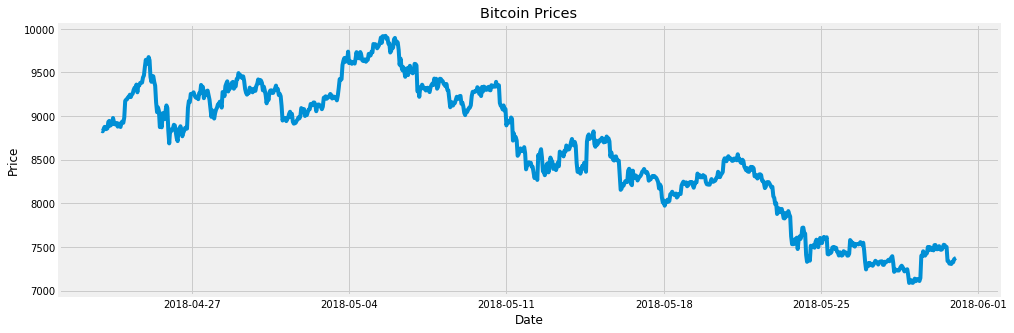

In [50]:
# ectracting the data as required, additional 125 periods are added in begining to account for moving average
df2 = df.ix[datetime.date(year=2018,month=4,day=23):datetime.date(year=2018,month=5,day=31)].copy()

# resample the dataframe to a 60min frequency
dfh  = pd.DataFrame()
dfh['open'] = df2.Open.resample('60Min', base = 30,loffset='30min').last()
dfh['high'] = df2.High.resample('60Min', base = 30, loffset='30min').last()
dfh['low'] = df2.Low.resample('60Min', base = 30, loffset='30min').last()
dfh['close'] = df2.Close.resample('60Min', base = 30, loffset='30min').last()
dfh['volume_btc'] = df2['Volume (BTC)'].resample('60Min', base = 30, loffset='30min').last()
dfh['volume_currency'] = df2['Volume (Currency)'].resample('60Min', base = 30, loffset='30min').last()
dfh['wtd_price'] = df2['Weighted Price'].resample('60Min', base = 30, loffset='30min').last()

# plot the bitcoin close price time series
plt.figure(figsize=(15,5))
plt.plot(dfh.index, dfh.close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Prices')

## Momentum indicator

In [51]:
dfh['90dema'] = pd.Series.ewm(dfh['close'], span=90, min_periods=90).mean() # calculate 90d EMA
dfh['30dema'] = pd.Series.ewm(dfh['close'], span=30, min_periods=30).mean() # calculare 30d EMA
dfh['mom'] = (dfh['90dema'] - dfh['30dema'])/dfh['90dema'] # calculate momentum indicator

# 45 day rolling mean and stdev for indicator
dfh['mom45mean'] = dfh['mom'].rolling(45, min_periods=45).mean()
dfh['mom45sigma'] = dfh['mom'].rolling(45, min_periods=45).std()
# deviation of current value from mean in terms of std dev
dfh['momfinal'] = abs(dfh['mom45mean'] - dfh['mom'])/dfh['mom45sigma']

dfh.drop(labels = ['90dema','30dema','mom','mom45mean','mom45sigma'], inplace=True, axis=1)

## Price / MA125 indicator

In [52]:
dfh['ma125'] = dfh['close'].rolling(125, min_periods=125).mean()
dfh['pricema'] = dfh['close'] / dfh['ma125']

dfh['pricemamean'] = dfh['pricema'].rolling(45,min_periods=45).mean()
dfh['pricemasigma'] = dfh['pricema'].rolling(45,min_periods=45).std()
dfh['pricemafinal'] = abs(dfh['pricemamean'] - dfh['pricema'])/dfh['pricemasigma']

dfh.drop(labels = ['ma125','pricema','pricemamean','pricemasigma'], inplace=True, axis=1)

## Implied volatility - VIX using GARCH(1,1)

In [53]:
dfh['pct'] = dfh['close'].pct_change() # calculate percentage return

def ar_forecast(returns):
    am = arch_model(returns*100, vol='Garch', p=1, o=0, q=1, dist='Normal') #initialize GARCH(1,1) model
    res = am.fit(update_freq=0,disp='off') # fit GARCH(1,1) model
    forecasts = res.forecast(horizon=12) # make forecast for next 24 periods
    return np.sqrt(forecasts.variance.iloc[-1,:].values.mean())*100 # calculate VIX using above stated formula

# apply on a rolling period
dfh['vix'] = dfh['pct'].rolling(window = 12, min_periods = 12).apply(ar_forecast)

dfh['vixmean'] = dfh['vix'].rolling(45,min_periods=45).mean()
dfh['vixsigma'] = dfh['vix'].rolling(45,min_periods=45).std()
dfh['vixfinal'] = abs(dfh['vixmean'] - dfh['vix'])/dfh['vixsigma']

dfh.drop(labels = ['pct','vix','vixmean','vixsigma'], inplace=True, axis=1)

## News sentiment analysis

In this project I have used two data sources for aggregating news with the keyword 'bitcoin' in its title. The data from 9 May 2018 to 8 May 2018 is aggregated using webhoseio api, but due to its limitation of not providing data for more that past 30 days in free version I had to aggregate news from 1 May 2018 to 7 May 2018 from newsapi.

In this section I extract the meaningful data and process it through vaderSentiment api for gauging the sentiment of the article. Later I aggregate the data on 60min interval and append to the original dataframe for further building of index.

In [10]:
# get list of all files in the news data folder
files = glob.glob("/home/cchopade/crypto_hackathon/data/news/*.txt")

# initialize vaderSentiment object
analyzer = SentimentIntensityAnalyzer()

# create empty dataframe to store data
news_data = pd.DataFrame(columns = ['published','title','text','neg','neu','pos','compound'])

# loop through each file, parse text, perform sentiment analysis and store to dataframe
for file in files:
    with open(file) as json_file:  
        data = json.load(json_file)


    # create a blank dictionary to convert the data in a pandas dataframe
    news_dict = { "published":[],
                    "title":[],
                    "text":[], "neg":[],
                    "neu": [],
                    "pos": [],
                    "compound":[]}

    for news in data['posts']:
        news_dict["published"].append(news['published'])
        news_dict["title"].append(news['title'])
        news_dict["text"].append(news['text'])
        vs = analyzer.polarity_scores(news['text'])
        news_dict["neg"].append(vs['neg'])
        news_dict["neu"].append(vs['neu'])
        news_dict["pos"].append(vs['pos'])
        news_dict["compound"].append(vs['compound'])

    
    news_data = news_data.append(pd.DataFrame(news_dict),ignore_index=True)

news_data.to_csv('data/news_analysis.csv') # save processed data to csv for future use

In [42]:
# get list of all files in the news data folder
files = glob.glob("/home/cchopade/crypto_hackathon/data/google_news/*.txt")

# initialize vaderSentiment object
analyzer = SentimentIntensityAnalyzer()

# create empty dataframe to store data
news_data = pd.DataFrame(columns = ['published','title','text','neg','neu','pos','compound'])

# loop through each file, parse text, perform sentiment analysis and store to dataframe
for file in files:
    with open(file) as json_file:  
        data = json.load(json_file)


# create a blank dictionary to convert the data in a pandas dataframe
news_dict = { "published":[],
                    "title":[],
                    "text":[], "neg":[],
                    "neu": [],
                    "pos": [],
                    "compound":[]}

    for news in data['articles']:
        news_dict["published"].append(news['publishedAt'])
        news_dict["title"].append(news['title'])
        news_dict["text"].append(news['description'])
        if news['description'] == None:
            vs = analyzer.polarity_scores(news['title'])
        else:
            vs = analyzer.polarity_scores(news['description'])
        news_dict["neg"].append(vs['neg'])
        news_dict["neu"].append(vs['neu'])
        news_dict["pos"].append(vs['pos'])
        news_dict["compound"].append(vs['compound'])

    
    news_data = news_data.append(pd.DataFrame(news_dict),ignore_index=True)

news_data.to_csv('data/google_news_analysis.csv') # save processed data to csv for future use

In [54]:
# collating news data from newsapi and webhose api and basic cleaning and sorting

dfn = pd.read_csv('data/news_analysis.csv')
dfn1 = pd.read_csv('data/google_news_analysis.csv')
dfn = dfn.append(dfn1, ignore_index=True)
dfn['published'] = pd.to_datetime(dfn['published'])
dfn.set_index(dfn.published,drop=True, inplace = True)
dfn.drop(labels = ['Unnamed: 0','compund','published'], inplace=True, axis = 1)
dfn.sort_index(inplace = True)
dfn.columns

Index(['compound', 'neg', 'neu', 'pos', 'text', 'title'], dtype='object')

In [55]:
# resampling data to match the market sentiment indicator timestamps
dfnh  = pd.DataFrame()
dfnh['compound'] = dfn['compound'].resample('60Min').mean()
dfnh['neg'] = dfn['neg'].resample('60Min').mean()
dfnh['neu'] = dfn['neu'].resample('60Min').mean()
dfnh['pos'] = dfn['pos'].resample('60Min').mean()

# min max normalization to convert scores from -1 to 1, to between 0 and 1
dfnh['compound'] = (dfnh['compound'] - dfnh['compound'].min())/(dfnh['compound'].max() - dfnh['compound'].min()) 

#concat the compound column to the original dataframe
dfh = pd.concat([dfh, dfnh['compound']], axis = 1)

## Google Search trend analysis

In [107]:
dfg = pd.read_csv('data/google.csv')
dfg.date = pd.to_datetime(dfg.date)
dfg.set_index(dfg.date, inplace = True)
dfg.drop(labels=['date','isPartial'], axis = 1, inplace=True)
dfg['googlemean'] = dfg['bitcoin'].rolling(45,min_periods=45).mean()
dfg['googlesigma'] = dfg['bitcoin'].rolling(45,min_periods=45).std()
dfg['googlefinal'] = abs(dfg['googlemean'] - dfg['bitcoin'])/dfg['googlesigma']
dfg.drop(labels = ['bitcoin','googlemean','googlesigma'], inplace = True,axis=1)
dfg = dfg.ix[datetime.date(year=2018,month=5,day=1):datetime.date(year=2018,month=5,day=31)]

# Constructing the index

In [160]:
# subset the dataset for required period
gfi = dfh.ix[datetime.date(year=2018,month=5,day=1):datetime.date(year=2018,month=5,day=27)]
gfi = gfi[['momfinal','pricemafinal','vixfinal','compound']] # drop columns that are not required
gfi = pd.merge(gfi,dfg,left_index=True, right_index=True) # merge the google search data

# parameter for min max normalization
max = gfi.max(axis=1)
min = gfi.min(axis=1)
denom = max - min

# nomralize the values for each day
gfi['momfinal'] = (gfi['momfinal'] - min)/denom
gfi['pricemafinal'] = (gfi['pricemafinal'] - min)/denom
gfi['vixfinal'] = (gfi['vixfinal'] - min)/denom
gfi['compound'] = (gfi['compound'] - min)/denom
gfi['googlefinal'] = (gfi['googlefinal'] - min)/denom

# calculate greed and fear index
gfi['gfi'] = gfi.mean(axis = 1)*100

# Backtesting

In [164]:
gfi['buy'] = [x for x in gfi['gfi'] < 30 ]
gfi['sell'] = [x for x in gfi['gfi'] > 60]

In [169]:
buy_dates = gfi.index[gfi['buy'] == True]
sell_dates = gfi.index[gfi['sell'] == True]

In [180]:
dfh.to_csv('data/processed_data.csv')